In [1]:
library(igraph)
library(tidyverse)
library(tidygraph)
library(ggnetwork)

vegas <- read_tsv('../preprocessing/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>%
    select(Gene, Pvalue)
ppi <- read_tsv('../preprocessing/BIOGRID-ORGANISM-Homo_sapiens-3.5.172.tab2.hgnc.txt') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ purrr::flatten()       masks jsonlite::flatten()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()

Attaching package: ‘tidygraph’

The following object is masked from ‘package:igraph

# Subnetworks

## LEAN

In [2]:
lean <- read_tsv('../lean/scored_genes.lean.txt', col_types = 'cdddddddd')
g_lean <- activate(ppi, nodes) %>%
    filter(name %in% lean$Gene[lean$PLEAN < 0.05])

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 12 rows containing missing values (geom_bar).”

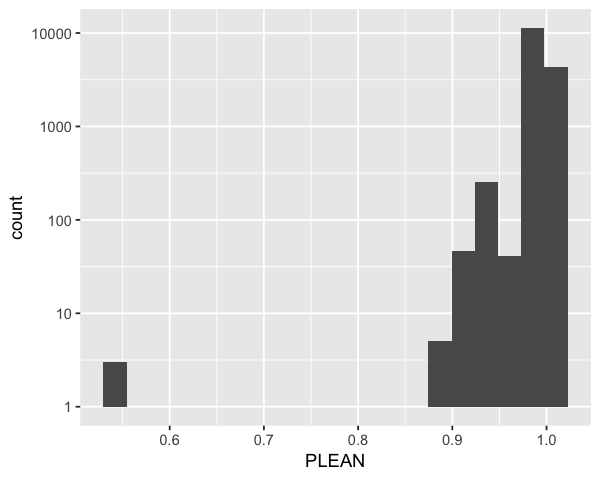

In [3]:
options(repr.plot.width=5, repr.plot.height=4)
ggplot(lean, aes(PLEAN)) +
    geom_histogram(bins = 20) +
    scale_y_log10()

## Sigmod

In [4]:
sigmod <- read_tsv('../sigmod/selected_genes.sigmod.txt', col_types = 'c')
g_sigmod <- activate(ppi, nodes) %>%
    filter(name %in% sigmod$gene) %>%
    mutate(sigmod = TRUE)
class(g_sigmod) <- c('igraph','tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Loading required package: sna
Loading required package: statnet.common

Attaching package: ‘statnet.common’

The following object is masked from ‘package:base’:

    order

Loading required package: network
network: Classes for Relational Data
Version 1.15 created on 2019-04-01.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: ‘network’

The following objects are masked from ‘package:igraph’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge

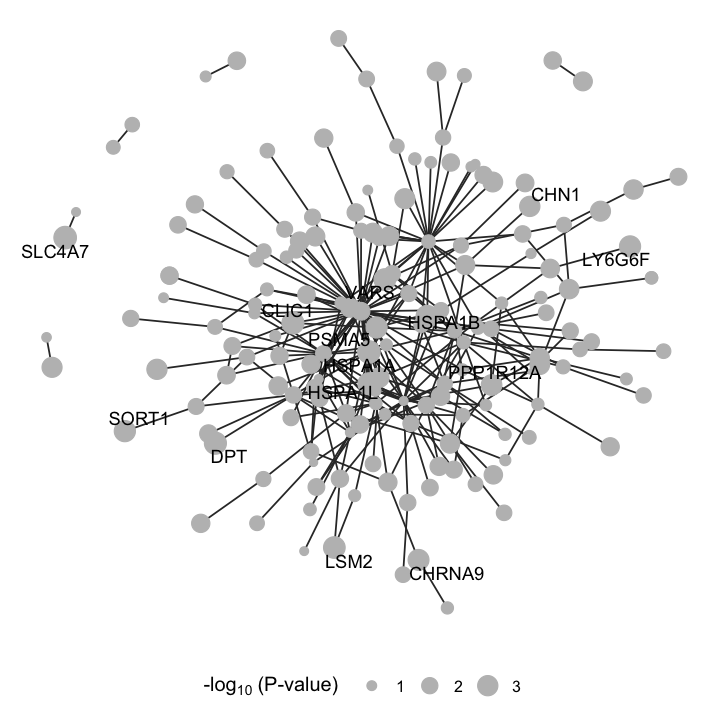

In [5]:
options(repr.plot.width=6, repr.plot.height=6)
g_sigmod %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(size = -log10(Pvalue)), color = 'gray') +
        geom_nodetext_repel(aes(label = ifelse(Pvalue < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(size = bquote('-log' [10] ~'(P-value)'))

## dmGWAS

In [6]:
dmgwas_subnets <- read_tsv('../dmgwas/subnetworks.tsv', col_types = 'cc')
num_seeds <- length(unique(dmgwas_subnets$seed))

dmgwas <- dmgwas_subnets %>%
    group_by(genes) %>%
    filter(n() >= (num_seeds * 0.01))

In [7]:
g_dmgwas <- activate(ppi, nodes) %>%
    filter(name %in% dmgwas$genes) %>%
    mutate(dmgwas = TRUE)
class(g_dmgwas) <- c('igraph','tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”

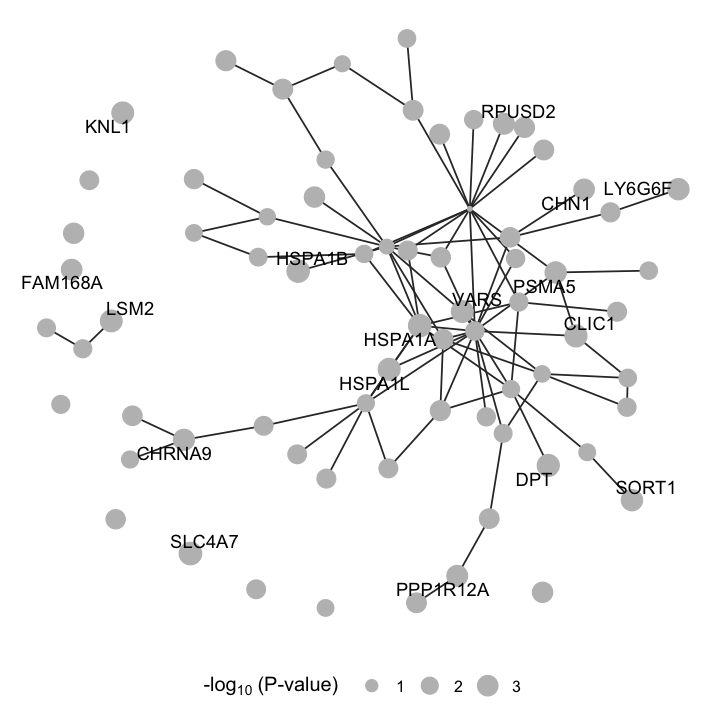

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
g_dmgwas %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(size = -log10(Pvalue)), color = 'gray') +
        geom_nodetext_repel(aes(label = ifelse(Pvalue < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(size = bquote('-log' [10] ~'(P-value)'))

## Hierarchical HotNet

In [9]:
hotnet <- read_tsv('../hotnet/selected_genes.hotnet.txt', comment = '#', col_names = F)
hotnet <- head(hotnet, nrow(hotnet) * 0.001) %>%
    gather(colname, gene) %>%
    filter(!is.na(gene)) %>%
    select(-colname)

Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message:
“15243 parsing failures.
row col   expected     actual                                  file
  2  -- 44 columns 12 columns '../hotnet/selected_genes.hotnet.txt'
  3  -- 44 columns 11 columns '../hotnet/selected_genes.hotnet.txt'
  4  -- 44 columns 11 columns '../hotnet/selected_genes.hotnet.txt'
  5  -- 44 columns 10 columns '../hotnet/selected_genes.hotnet.txt'
  6  -- 44 columns 9 columns  '../hotnet/selected_genes.hotnet.txt'
... ... .......... .......... .....................................
See problems(...) for more details.
”

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”

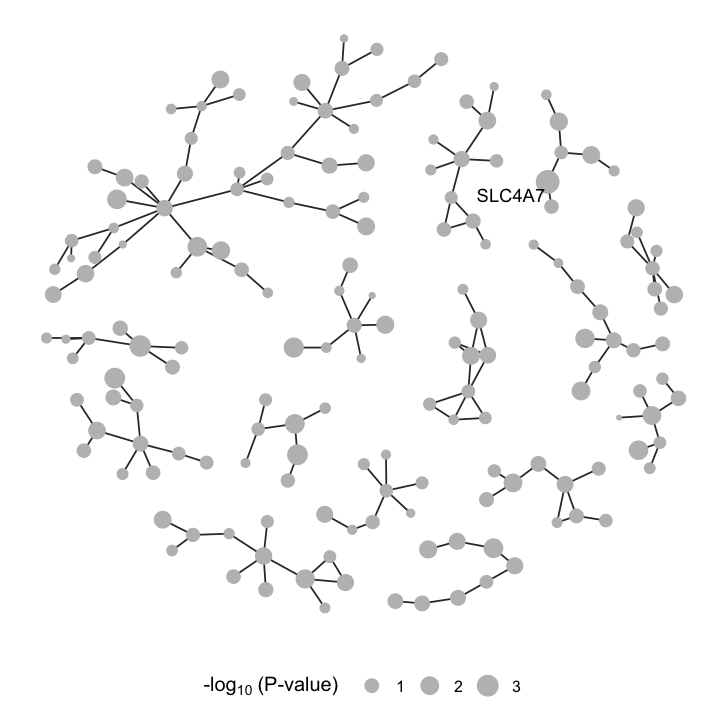

In [10]:
g_hotnet <- activate(ppi, nodes) %>%
    filter(name %in% hotnet$gene) %>%
    mutate(hotnet = TRUE)
class(g_hotnet) <- c('igraph','tbl_graph')

options(repr.plot.width=6, repr.plot.height=6)
g_hotnet %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(size = -log10(Pvalue)), color = 'gray') +
        geom_nodetext_repel(aes(label = ifelse(Pvalue < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(size = bquote('-log' [10] ~'(P-value)'))

## Heinz

In [11]:
heinz <- read_tsv('../heinz/selected_genes.heinz.txt', col_types = 'c')

heinz

gene
<chr>
TOX3


In [12]:
g_heinz <- activate(ppi, nodes) %>%
    filter(name %in% heinz$gene) %>%
    mutate(heinz = TRUE)
class(g_heinz) <- c('igraph','tbl_graph')

# Consensus subnetwork

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”

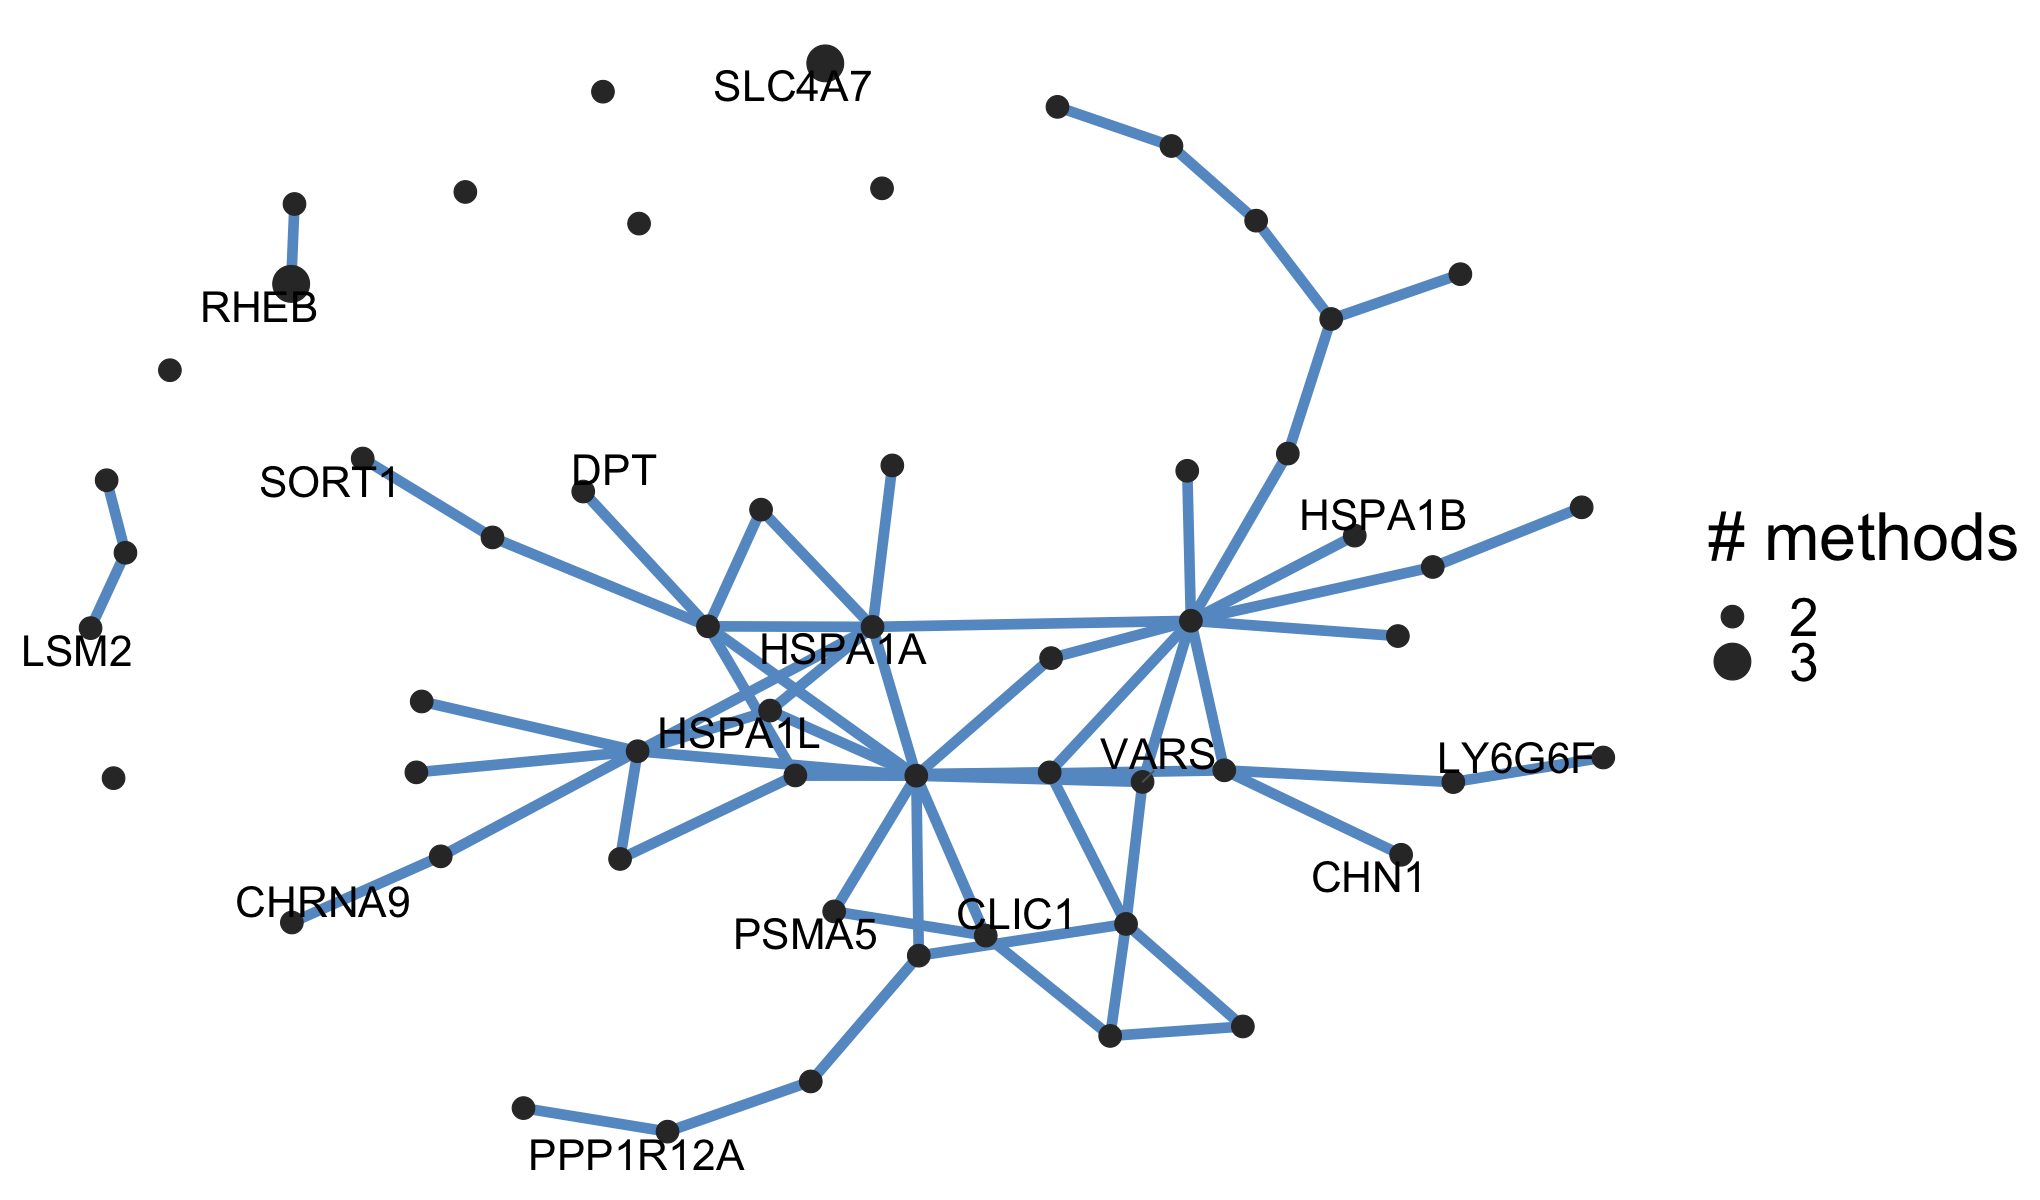

In [13]:
options(repr.plot.width=17, repr.plot.height=10)
graph_join(g_sigmod, g_dmgwas, by = "name") %>%
    graph_join(g_hotnet, by = "name") %>%
    graph_join(g_heinz, by = "name") %>%
    to_undirected %>%
    mutate(num_methods = rowSums(cbind(dmgwas, sigmod, hotnet, heinz), na.rm = TRUE)) %>%
    filter(num_methods > 1) %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(size = 3, color = '#6699CC') +
        geom_nodes(aes(size = as.character(num_methods)), color = 'gray20') +
        geom_nodetext_repel(aes(label = ifelse(num_methods == 3 | Pvalue < 0.001, vertex.names, '')), size = 9) +
        theme_blank() +
        labs(size = '# methods') +
        scale_size_manual(values = c('2' = 6, '3' = 10)) +
        theme(text = element_text(size = 40))